<a href="https://colab.research.google.com/github/pythonuzgit/elmurodov/blob/master/Multiclass_image_classification_with_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import the necessary packages to use in this project

In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import imshow

from pathlib import Path
import os.path

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

import tensorflow as tf
from keras import layers
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input

from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout

from keras.models import Model
import keras.backend as K 
from keras.models import Sequential

In [8]:
train_dir = Path('/content/train')
test_dir = Path('/content/test')
validation_dir = Path('/content/validation')

Get filepath and lebels

In [9]:
filepaths_train = list(train_dir.glob(r'**/*.jpg'))
filepaths_test = list(train_dir.glob(r'**/*.jpg'))
filepaths_valid = list(train_dir.glob(r'**/*.jpg'))

In [10]:
def proc_img(filepath):
  labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepath))

  filepath = pd.Series(filepath, name = 'Filepath').astype(str)
  labels = pd.Series(labels, name = 'Labels')

  df = pd.concat([filepath, labels], axis = 1)

  df = df.sample(frac = 1).reset_index(drop = True)

  return df


train_df = proc_img(filepaths_train)
test_df = proc_img(filepaths_test)
val_df = proc_img(filepaths_valid)

train_df.head()


,Filepath,Labels
0,/content/train/sweetpotato/Image_34.jpg,sweetpotato
1,/content/train/capsicum/Image_13.jpg,capsicum
2,/content/train/sweetpotato/Image_38.jpg,sweetpotato
3,/content/train/turnip/Image_94.jpg,turnip
4,/content/train/sweetpotato/Image_24.jpg,sweetpotato


In [11]:
print(f'Number of training pictures: {train_df.shape[0]}')
print(f'Number of training pictures: {test_df.shape[0]}')
print(f'Number of training pictures: {val_df.shape[0]}')

Number of training pictures: 3193
Number of training pictures: 3193
Number of training pictures: 3193


Display is picture of the dataset with their labels

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


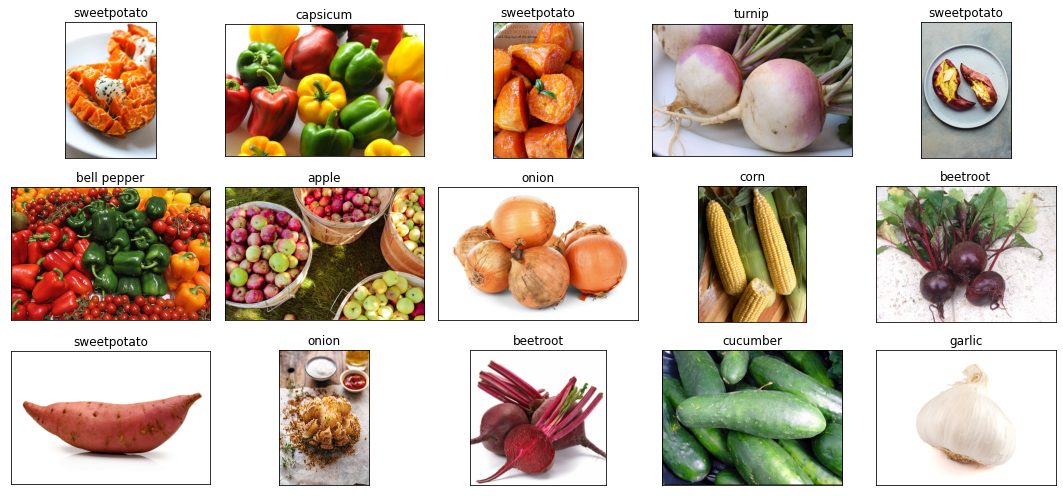

In [12]:

fig, axes = plt.subplots(nrows = 3, ncols = 5, figsize = (15, 7), 
                        subplot_kw = {'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
  ax.imshow(plt.imread(train_df.Filepath[i]))
  ax.set_title(train_df.Labels[i])



plt.tight_layout()
plt.show()  

Load the Images

In [13]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [14]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input
)

val_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input
)

In [15]:
train_images = train_generator.flow_from_dataframe(
    dataframe = train_df, 
    x_col = 'Filepath',
    y_col = 'Labels',
    target_size = (224, 224),
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = 32,
    shuffle = True,
    seed = 0,
    #subset = 'training',
    rotation_range = 30,
    zoom_range = 0.15,
    width_shift_range = 0.2,
    heifht_shift_range = 0.2,
    shear_range = 0.15,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

val_images = val_generator.flow_from_dataframe(
    dataframe = val_df, 
    x_col = 'Filepath',
    y_col = 'Labels',
    target_size = (224, 224),
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = 32,
    shuffle = True,
    seed = 0,
    #subset = 'training',
    rotation_range = 30,
    zoom_range = 0.15,
    width_shift_range = 0.2,
    heifht_shift_range = 0.2,
    shear_range = 0.15,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

test_images = test_generator.flow_from_dataframe(
    dataframe = test_df, 
    x_col = 'Filepath',
    y_col = 'Labels',
    target_size = (224, 224),
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = 32,
    shuffle = False
    )

Found 3193 validated image filenames belonging to 36 classes.
Found 3193 validated image filenames belonging to 36 classes.
Found 3193 validated image filenames belonging to 36 classes.


Load the pretrained model

In [16]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape = (224, 224, 3),
    include_top = False,
    weights = 'imagenet',
    pooling = 'avg'
)

pretrained_model.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


Train the model

In [17]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation = 'relu')(pretrained_model.output)

x = tf.keras.layers.Dense(128, activation = 'relu')(x)

outputs = tf.keras.layers.Dense(36, activation = 'softmax')(x)

model = tf.keras.Model(inputs = inputs, outputs = outputs)


model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [18]:
history = model.fit(train_images, validation_data = val_images, epochs = 10, 
                    batch_size = 32, verbose = 1)

Epoch 1/10
 19/100 [====>.........................] - ETA: 2:37 - loss: 3.2296 - accuracy: 0.1864

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


 62/100 [=================>............] - ETA: 1:14 - loss: 2.2264 - accuracy: 0.4269

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


100/100 [==============================] - 402s 4s/step - loss: 1.8368 - accuracy: 0.5096 - val_loss: 0.7434 - val_accuracy: 0.7745
Epoch 2/10
100/100 [==============================] - 394s 4s/step - loss: 0.6858 - accuracy: 0.7924 - val_loss: 0.4072 - val_accuracy: 0.8804
Epoch 3/10
100/100 [==============================] - 394s 4s/step - loss: 0.4184 - accuracy: 0.8656 - val_loss: 0.2438 - val_accuracy: 0.9349
Epoch 4/10
100/100 [==============================] - 398s 4s/step - loss: 0.2515 - accuracy: 0.9264 - val_loss: 0.1662 - val_accuracy: 0.9590
Epoch 5/10
100/100 [==============================] - 396s 4s/step - loss: 0.1679 - accuracy: 0.9552 - val_loss: 0.1029 - val_accuracy: 0.9812
Epoch 6/10
100/100 [==============================] - 396s 4s/step - loss: 0.1200 - accuracy: 0.9662 - val_loss: 0.0819 - val_accuracy: 0.9843
Epoch 7/10
100/100 [==============================] - 399s 4s/step - loss: 0.0905 - accuracy: 0.9734 - val_loss: 0.0645 - val_accuracy: 0.9847
Epoch 8/10

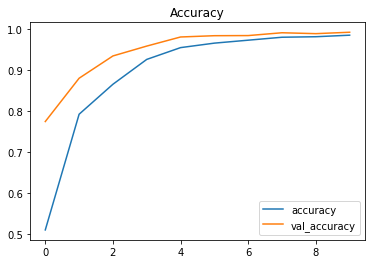

In [19]:
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()

plt.title('Accuracy')
plt.show()

Visualize the result

In [22]:
results = model.evaluate(test_images, verbose=0)

print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Test Loss: 0.03400
Test Accuracy: 99.28%


In [25]:
pred = model.predict(test_images)
pred = np.argmax(pred, axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


The first 5 predictions: ['cabbage', 'cabbage', 'jalepeno', 'potato', 'apple']


Examples of Prediction

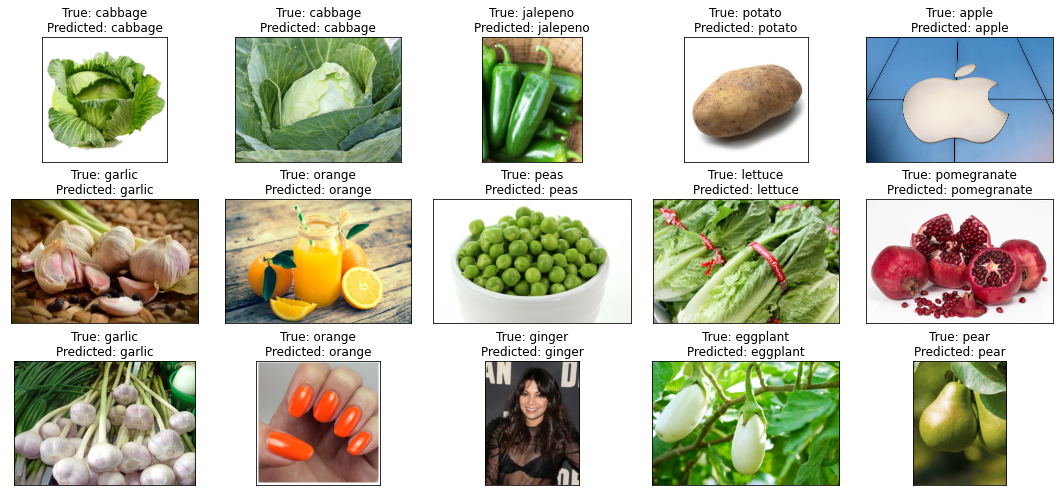

In [26]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Labels.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()